In [1]:
import pennylane as qml

from pennylane import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [2]:
def draw(circuit, *args, **kwargs):

    qml.draw_mpl(circuit, style="solarized_dark", decimals=2)(*args, **kwargs)
    plt.gcf().set_dpi(50)

### Data

In [3]:
def create_dataset(samples_count=100):

    samples_per_class = samples_count // 2

    class_0_xs = np.random.normal(loc=-1, scale=1, size=samples_per_class)
    class_0_ys = np.random.normal(loc=1, scale=1, size=samples_per_class)

    class_1_xs = np.random.normal(loc=1, scale=1, size=samples_per_class)
    class_1_ys = np.random.normal(loc=-1, scale=1, size=samples_per_class)

    plt.scatter(class_0_xs, class_0_ys, label="Class 0")
    plt.scatter(class_1_xs, class_1_ys, label="Class 1")
    plt.legend()
    plt.show()

    # Coordinates

    class_0_coordinates = np.stack([class_0_xs, class_0_ys]).T
    class_1_coordinates = np.stack([class_1_xs, class_1_ys]).T

    all_coordinates = np.concatenate([class_0_coordinates, 
                                      class_1_coordinates])

    # Labels

    class_0_labels = -np.ones(samples_per_class)
    class_1_labels = np.ones(samples_per_class)

    all_labels = np.concatenate([class_0_labels, class_1_labels])

    # Data

    data = list(zip(all_coordinates, all_labels))

    data_df = pd.DataFrame(data, columns=["Coordinates", "Label"])

    display(data_df.head(3))
    
    return data

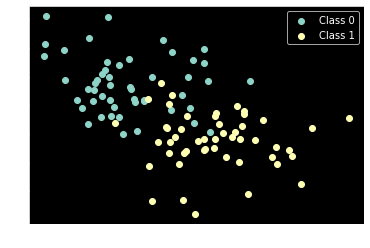

,Coordinates,Label
0,"[-1.1020716255592697, 0.7267514137777839]",-1.0
1,"[0.5918090532798954, 1.5836626090066437]",-1.0
2,"[-1.4357212998932756, 0.5288506608718082]",-1.0


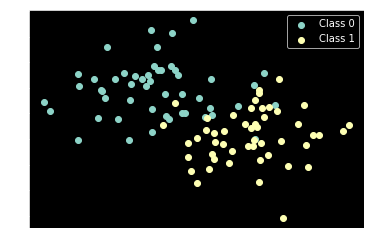

,Coordinates,Label
0,"[-2.7548629228298367, 1.0804607843158143]",-1.0
1,"[-0.912402355194196, 0.772164779643375]",-1.0
2,"[-1.798594018852909, 1.596504276693325]",-1.0


In [5]:
dataset_good = create_dataset()
dataset_bad = create_dataset()

In [6]:
QUBITS_COUNT = 2
LAYERS_COUNT = 1

qubits = list(range(QUBITS_COUNT))

qml_device = qml.device('default.qubit', wires=qubits)


# Model

@qml.qnode(qml_device)
def quantum_model(angles_1, angles_2, weights):
    
    qml.templates.AngleEmbedding(angles_1, wires=qubits)
    
    qml.Barrier(only_visual=True)
    
    qml.templates.BasicEntanglerLayers(weights, wires=qubits)
    
    qml.Barrier(only_visual=True)
        
    # qml.templates.AngleEmbedding(angles_2, wires=qubits, do_queue=False).decomposition()
    
    qml.adjoint(qml.templates.AngleEmbedding(angles_1, wires=qubits))
    
    qml.Barrier(only_visual=True)
    
    return [qml.expval(qml.PauliZ(wires=qubit)) for qubit in qubits]

In [7]:
angles_1 = np.array(dataset_good[0][0], requires_grad=False)
angles_2 = np.array(dataset_bad[0][0], requires_grad=False)

weights = np.random.random(size=(LAYERS_COUNT, QUBITS_COUNT))

In [8]:
angles_2

tensor([-2.75486292,  1.08046078], requires_grad=False)

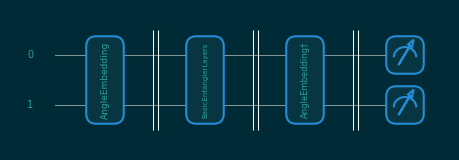

In [9]:
draw(quantum_model, angles_1, angles_2, weights)

In [43]:
# Quantum Model

@qml.qnode(qml_device)
def quantum_model(angles_1, angles_2, weights):
    
    # print("angles_1:", angles_1)
    # print("angles_2:", angles_2)
    # print("weights:", weights)
    
    qml.templates.AngleEmbedding(angles_1, wires=qubits)
    
    qml.Barrier(only_visual=True)
    
    qml.templates.BasicEntanglerLayers(weights, wires=qubits)
    
    qml.Barrier(only_visual=True)
        
    # qml.templates.AngleEmbedding(angles_2, wires=qubits, do_queue=False).decomposition()
    
    qml.adjoint(qml.templates.AngleEmbedding(angles_1, wires=qubits))
    
    qml.Barrier(only_visual=True)
    
    result = [qml.expval(qml.PauliZ(wires=qubit)) for qubit in qubits]
    # result = qml.expval(qml.PauliZ(wires=0))
    
    # print("result:", result)
    
    return result


# Loss

def loss(label_predicted, label_real):
    
    return (label_predicted - label_real) ** 2


# Average Loss

def average_loss_with_bias(weights, dataset_good, dataset_bad):
    
    total_loss = 0
    
    for datapoint_good, datapoint_bad in zip(dataset_good, dataset_bad):
        
        coodinates_good, label_good = datapoint_good
        coodinates_bad, label_bad = datapoint_bad
        
        predictions = quantum_model(coodinates_good, coodinates_bad, weights)
        
        prediction = np.sum(predictions)
        
        # print("predictions:", predictions)
        # print("prediction:", prediction)
        
        label = label_good = label_bad
        
        total_loss += loss(prediction, label)
        
    average_loss = total_loss / len(dataset_good)
        
    return average_loss


# Gradient functions

average_loss_gradient_weights = qml.grad(average_loss_with_bias, argnum=0)


# Training

# weights = np.random.random(size=(3, 2)) * 3

weights = np.random.random(size=(LAYERS_COUNT, QUBITS_COUNT))

optimizer = qml.GradientDescentOptimizer(stepsize=0.05)

In [44]:
weights

tensor([[0.67717702, 0.09952007]], requires_grad=True)

In [45]:
def optimization_step_function(weights):
    
    current_loss = average_loss_with_bias(weights, dataset_good, dataset_bad)
    
    return current_loss
    

losses = []
# selected_weights = []
    
for step in range(5):
    
    step_result = optimizer.step_and_cost(optimization_step_function, weights)
    
    print("step_result:", step_result)
    
    (weights, current_loss) = step_result
    
    losses.append(current_loss)
    # selected_weights.append((weights[0, 0],
    #                          weights[1, 0]))
    
    print("current_loss:", current_loss)
    
    print(current_loss)

step_result: (tensor([[0.65715294, 0.10934801]], requires_grad=True), tensor(2.7151219, requires_grad=True))
current_loss: 2.7151219031140754
2.7151219031140754
step_result: (tensor([[0.63661148, 0.12008287]], requires_grad=True), tensor(2.70497852, requires_grad=True))
current_loss: 2.704978522370248
2.704978522370248
step_result: (tensor([[0.61552245, 0.13179713]], requires_grad=True), tensor(2.69401749, requires_grad=True))
current_loss: 2.6940174904411482
2.6940174904411482
step_result: (tensor([[0.59385454, 0.14456675]], requires_grad=True), tensor(2.68213266, requires_grad=True))
current_loss: 2.6821326573070996
2.6821326573070996
step_result: (tensor([[0.57157558, 0.15847083]], requires_grad=True), tensor(2.66920438, requires_grad=True))
current_loss: 2.669204376056192
2.669204376056192
